# Cocoa Price Forecasting: Weighted Local Linear vs Machine Learning Methods

**Project:** Empirical Validation of the CGS Weighted Local Linear Framework

**Reference:** Cai, Gao, Selk (2025) - Nonparametric Time Series Forecasting with Structural Breaks

---

## Abstract

This notebook implements the experimental framework to validate the Cai-Gao-Selk (CGS) weighted local linear methodology on cocoa price data.

### Models Evaluated

| Category | Model | Data Usage | Description |
|----------|-------|------------|-------------|
| NP Benchmarks | Pre-Break LL | Pre-break only | High bias, low variance baseline |
| | Post-Break LL | Post-break only | Low bias, high variance baseline |
| | Weighted LL (WLL) | Combined | CGS convex combination with MFV-tuned gamma |
| ML Competitors | Random Forest | Full sample | Ensemble bagging method |
| | XGBoost | Full sample | Gradient boosting method |
| ML Extension | RF Weighted Combo | Combined | CGS weighting applied to RF |
| | XGB Weighted Combo | Combined | CGS weighting applied to XGB |

### Evaluation Metrics
- **Primary:** Out-of-Sample Mean Squared Forecast Error (MSFE)
- **Secondary:** Modified Diebold-Mariano (MDM) test for pairwise comparisons

## 1. Environment Setup

In [1]:
# Install required packages
import subprocess
import sys

# Install torch (required for NP models) and the local package
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'torch', '-q'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-e', '..', '-q'])

print('Dependencies installed successfully.')

Dependencies installed successfully.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product
from typing import Dict, Any, List, Tuple
from scipy import stats
from datetime import datetime

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Color scheme for models
COLORS = {
    'pre_break': '#E74C3C',
    'post_break': '#3498DB',
    'wll': '#2ECC71',
    'rf': '#9B59B6',
    'xgb': '#F39C12',
    'rf_combo': '#1ABC9C',
    'xgb_combo': '#E67E22',
}

print('Standard libraries imported.')

Standard libraries imported.


In [3]:
# Project modules
import sys
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from cocoa.data.features import build_features
from cocoa.models.np_combo import NPConvexCombinationModel
from cocoa.models.np_regime import NPRegimeModel
from cocoa.models.np_engines import LocalPolynomialEngine
from cocoa.models.np_kernels import EpanechnikovKernel
from cocoa.models.ml_models import RFModel, XGBModel
from cocoa.models.ml_combo import MLConvexCombinationModel
from cocoa.models.bandwidth import create_precentered_grid
from cocoa.models.mfv_CV import MFVValidator, MFVConvexComboValidator
from cocoa.models.evaluation import mean_squared_error
from cocoa.models.assets import (
    BREAK_ID_ONE_BASED, OOS_START_DATE, PROCESSED_DATA_PATH,
    DEFAULT_FEATURE_COLS, DEFAULT_TARGET_COL, Q_VALUE,
    RF_PARAM_GRID, XGB_PARAM_GRID,
)

print('Project modules imported.')

Project modules imported.


## 2. Data Loading and Exploration

In [4]:
# Load processed data
DATA_PATH = Path(PROCESSED_DATA_PATH)

if not DATA_PATH.exists():
    print('Processed data not found. Building from raw data...')
    project_root = Path.cwd().parent
    df = build_features(
        project_root / 'data' / 'raw',
        project_root / 'data' / 'processed',
        reading_path='Ghana_data_full.csv',
        file_name='cocoa_ghana_full.csv'
    )
else:
    df = pd.read_csv(DATA_PATH)

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

print(f'Dataset: {len(df):,} observations')
print(f'Date range: {df["date"].min().strftime("%Y-%m-%d")} to {df["date"].max().strftime("%Y-%m-%d")}')
print(f'Columns: {list(df.columns)}')
df.head()

Dataset: 6,734 observations
Date range: 1994-10-04 to 2025-02-26
Columns: ['date', 'PRCP_anom_mean', 'TAVG_anom_mean', 'PRCP_anom_std', 'TAVG_anom_std', 'N_stations', 'log_price', 'log_price_lagt', 'log_return', 'log_return_forecast_target']


,date,PRCP_anom_mean,TAVG_anom_mean,PRCP_anom_std,TAVG_anom_std,N_stations,log_price,log_price_lagt,log_return,log_return_forecast_target
0,1994-10-04,0.0000,0.25,0.000000,0.000000,1,7.287752,7.290457,-0.002704,-0.021924
1,1994-10-05,0.0925,0.00,0.137886,2.828427,2,7.265828,7.287752,-0.021924,-0.000175
2,1994-10-06,0.0040,-0.40,0.005657,0.565685,2,7.265653,7.265828,-0.000175,-0.009737
3,1994-10-07,-0.0284,0.46,0.377151,1.306905,5,7.255916,7.265653,-0.009737,-0.001929
4,1994-10-10,-0.4325,-4.00,0.000000,0.000000,1,7.253987,7.255916,-0.001929,0.000149


Structural Break Configuration:
  Break Index: 6116
  Break Date: 2022-09-23
  Pre-break observations: 6,116
  Post-break observations: 618


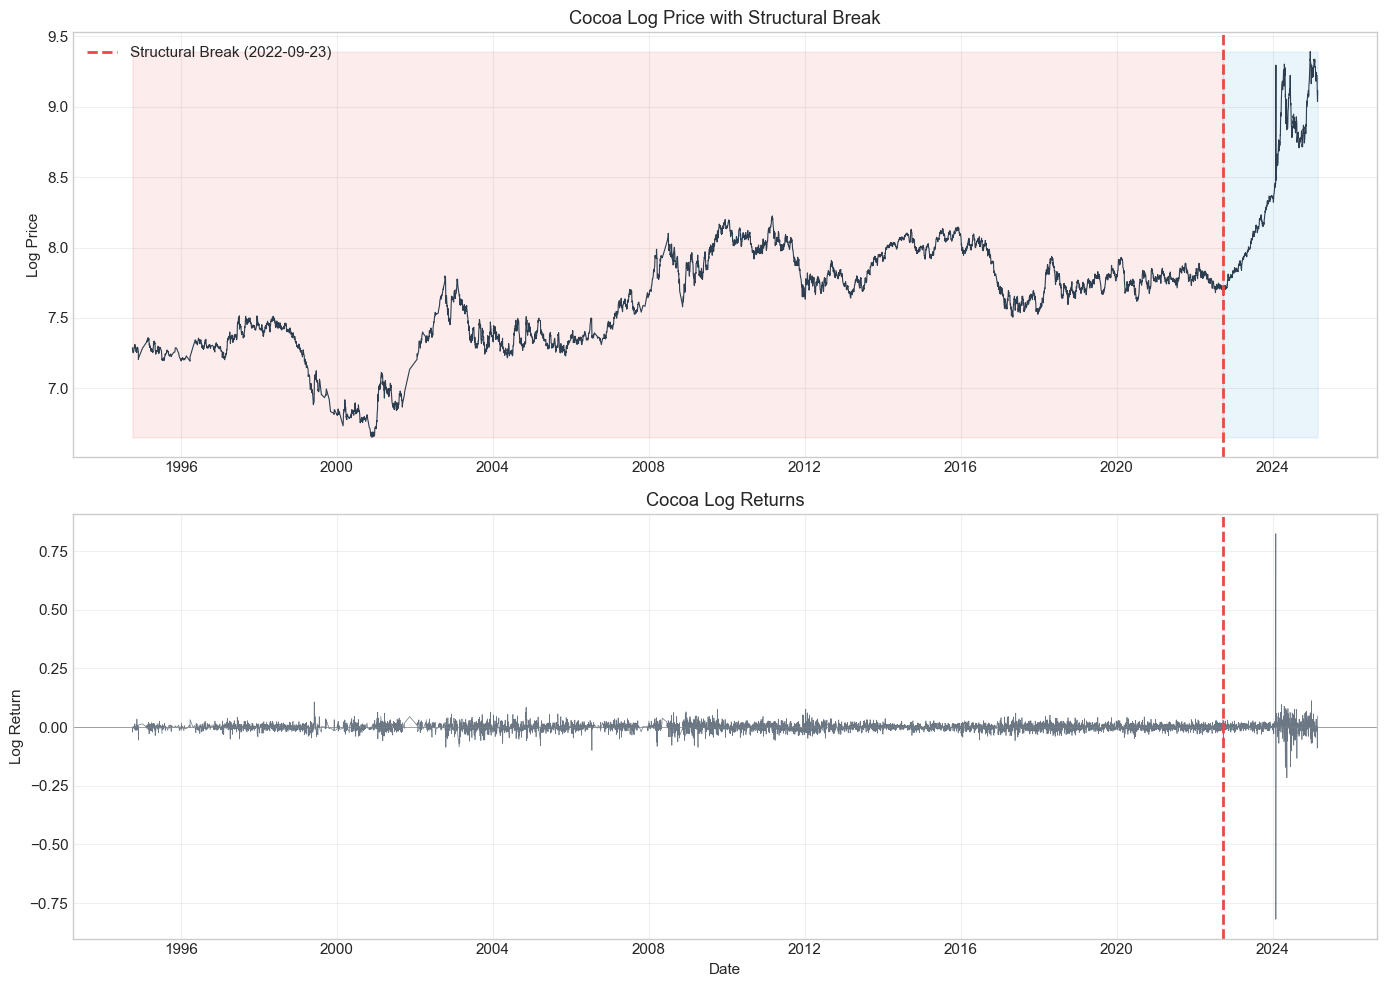


Summary Statistics by Regime:
  Pre-break  - Mean: 0.000075, Std: 0.015553, N: 6116
  Post-break - Mean: 0.002491, Std: 0.071729, N: 618


In [5]:
# Structural break configuration
BREAK_INDEX = BREAK_ID_ONE_BASED - 1  # Convert to 0-based
BREAK_DATE = df.iloc[BREAK_INDEX]['date']

print(f'Structural Break Configuration:')
print(f'  Break Index: {BREAK_INDEX}')
print(f'  Break Date: {BREAK_DATE.strftime("%Y-%m-%d")}')
print(f'  Pre-break observations: {BREAK_INDEX:,}')
print(f'  Post-break observations: {len(df) - BREAK_INDEX:,}')

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Log Price
ax1 = axes[0]
ax1.plot(df['date'], df['log_price'], color='#2C3E50', linewidth=0.8)
ax1.axvline(x=BREAK_DATE, color='#E74C3C', linestyle='--', linewidth=2,
            label=f'Structural Break ({BREAK_DATE.strftime("%Y-%m-%d")})')
ax1.fill_between(df['date'], df['log_price'].min(), df['log_price'].max(),
                 where=df['date'] < BREAK_DATE, alpha=0.1, color=COLORS['pre_break'])
ax1.fill_between(df['date'], df['log_price'].min(), df['log_price'].max(),
                 where=df['date'] >= BREAK_DATE, alpha=0.1, color=COLORS['post_break'])
ax1.set_ylabel('Log Price')
ax1.set_title('Cocoa Log Price with Structural Break')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Log Returns
ax2 = axes[1]
ax2.plot(df['date'], df['log_return'], color='#2C3E50', linewidth=0.5, alpha=0.7)
ax2.axvline(x=BREAK_DATE, color='#E74C3C', linestyle='--', linewidth=2)
ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Date')
ax2.set_ylabel('Log Return')
ax2.set_title('Cocoa Log Returns')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print('\nSummary Statistics by Regime:')
pre_ret = df.iloc[:BREAK_INDEX]['log_return']
post_ret = df.iloc[BREAK_INDEX:]['log_return']
print(f'  Pre-break  - Mean: {pre_ret.mean():.6f}, Std: {pre_ret.std():.6f}, N: {len(pre_ret)}')
print(f'  Post-break - Mean: {post_ret.mean():.6f}, Std: {post_ret.std():.6f}, N: {len(post_ret)}')

## 3. Structural Break Detection

### Methodology: Mohr-Selk (2020)

Following the recommendation in Cai, Gao, Selk (2025), we employ the nonparametric break detection method of Mohr and Selk (2020) to identify the structural break date in a data-driven manner.

**Algorithm Overview:**

1. **Pilot Estimation**: Compute a nonparametric pilot estimate $\hat{m}(x)$ of the conditional mean using local linear regression with bandwidth selected via MFV cross-validation.

2. **Residual Calculation**: Obtain residuals $\hat{U}_t = Y_t - \hat{m}(X_t)$.

3. **Truncation Weights**: Define indicator weights $\omega_t = \mathbf{1}\{X_t \in [-R_T, R_T]^d\}$ where $R_T = (\log T)^{1/(d+1)}$ to handle boundary effects.

4. **Kolmogorov-Smirnov Functional**: For each candidate break point $k$, compute:
   $$D_T(k) = \max_j \left| \sum_{t=1}^{k} \frac{\hat{U}_t \omega_t}{T} \mathbf{1}\{X_t \leq X_j\} \right|$$

5. **Break Date Estimation**: The estimated break date is $\hat{\tau} = \arg\max_k D_T(k)$, searched over a trimmed interior of the sample.

This method is consistent under the assumption that the log-return series is strong mixing within each regime.

In [6]:
# Structural Break Detection using Mohr-Selk (2020) Method
from cocoa.experiments.break_detection import estimate_break_mohr_ll
from cocoa.models.np_regime import NPRegimeModel
from cocoa.models.np_kernels import GaussianKernel
from cocoa.models.np_engines import LocalPolynomialEngine
from cocoa.models.bandwidth import create_precentered_grid
from functools import partial

print('Running Mohr-Selk (2020) Break Detection...')
print('='*60)

# Use config from assets
FEATURE_COLS = DEFAULT_FEATURE_COLS.copy()
TARGET_COL = DEFAULT_TARGET_COL

# Prepare data for break detection (full training sample)
train_mask_full = df['date'] < pd.to_datetime(OOS_START_DATE)
X_train_break = df.loc[train_mask_full, FEATURE_COLS].values
y_train_break = df.loc[train_mask_full, TARGET_COL].values
dates_train = df.loc[train_mask_full, 'date'].values

T_break, d_break = X_train_break.shape
print(f'Sample size for break detection: T = {T_break}')
print(f'Dimension: d = {d_break}')

# Step 1: Select pilot bandwidth via MFV
print('\nStep 1: Selecting pilot bandwidth via MFV cross-validation...')
pilot_kernel = GaussianKernel()
pilot_engine = LocalPolynomialEngine(order=1, use_gpu=True)
pilot_bandwidth_grid = create_precentered_grid(T=T_break, d=d_break)

# Use MFV to find optimal pilot bandwidth
mfv_pilot = MFVValidator(Q=Q_VALUE)
pilot_param_grid = [
    {'kernel': pilot_kernel, 'local_engine': pilot_engine, 'bandwidth': h}
    for h in pilot_bandwidth_grid
]

X_train_break_df = pd.DataFrame(X_train_break, columns=FEATURE_COLS)
y_train_break_s = pd.Series(y_train_break)

best_pilot_params, best_pilot_mse, _ = mfv_pilot.grid_search(
    model_class=NPRegimeModel,
    X_train=X_train_break_df,
    y_train=y_train_break_s,
    param_grid=pilot_param_grid,
    verbose=False
)
pilot_h = best_pilot_params['bandwidth']
print(f'  Selected pilot bandwidth: h = {pilot_h:.4f}')
print(f'  Pilot MFV MSE: {best_pilot_mse:.6f}')

# Step 2: Compute pilot estimates
print('\nStep 2: Computing pilot estimates...')
m_hat = pilot_engine.fit(
    X_train_break_df, y_train_break_s,
    X_train_break_df, pilot_h, pilot_kernel
)
print(f'  Pilot estimates computed for {len(m_hat)} observations')

# Step 3: Estimate break date
print('\nStep 3: Estimating break date via KS functional maximization...')
T1_hat = estimate_break_mohr_ll(
    y=y_train_break,
    X=X_train_break,
    m_hat=m_hat,
    trim_frac=0.05  # Trim 5% from each end
)

detected_break_date = dates_train[T1_hat - 1]  # Convert to 0-based for indexing
detected_break_date_str = pd.Timestamp(detected_break_date).strftime('%Y-%m-%d')

print(f'\nResults:')
print(f'  Estimated break index (1-based): {T1_hat}')
print(f'  Estimated break date: {detected_break_date_str}')
print(f'  Configured break index: {BREAK_ID_ONE_BASED}')
print(f'  Configured break date: {BREAK_DATE.strftime("%Y-%m-%d")}')

Running Mohr-Selk (2020) Break Detection...
Sample size for break detection: T = 6694
Dimension: d = 1

Step 1: Selecting pilot bandwidth via MFV cross-validation...
LocalPolynomialEngine will use device: cuda
Creating bandwidth grid with T=6694, d=1
Generated bandwidth grid: [0.01717366 0.02864739 0.04778673 0.07971307 0.13296941 0.22180635
 0.36999529 0.61718934 1.02953386 1.71736599]
Set block size to 1338 for training length 6694 and Q=4.


  Selected pilot bandwidth: h = 1.7174
  Pilot MFV MSE: 0.000813

Step 2: Computing pilot estimates...
  Pilot estimates computed for 6694 observations

Step 3: Estimating break date via KS functional maximization...



Results:
  Estimated break index (1-based): 6117
  Estimated break date: 2022-09-23
  Configured break index: 6117
  Configured break date: 2022-09-23


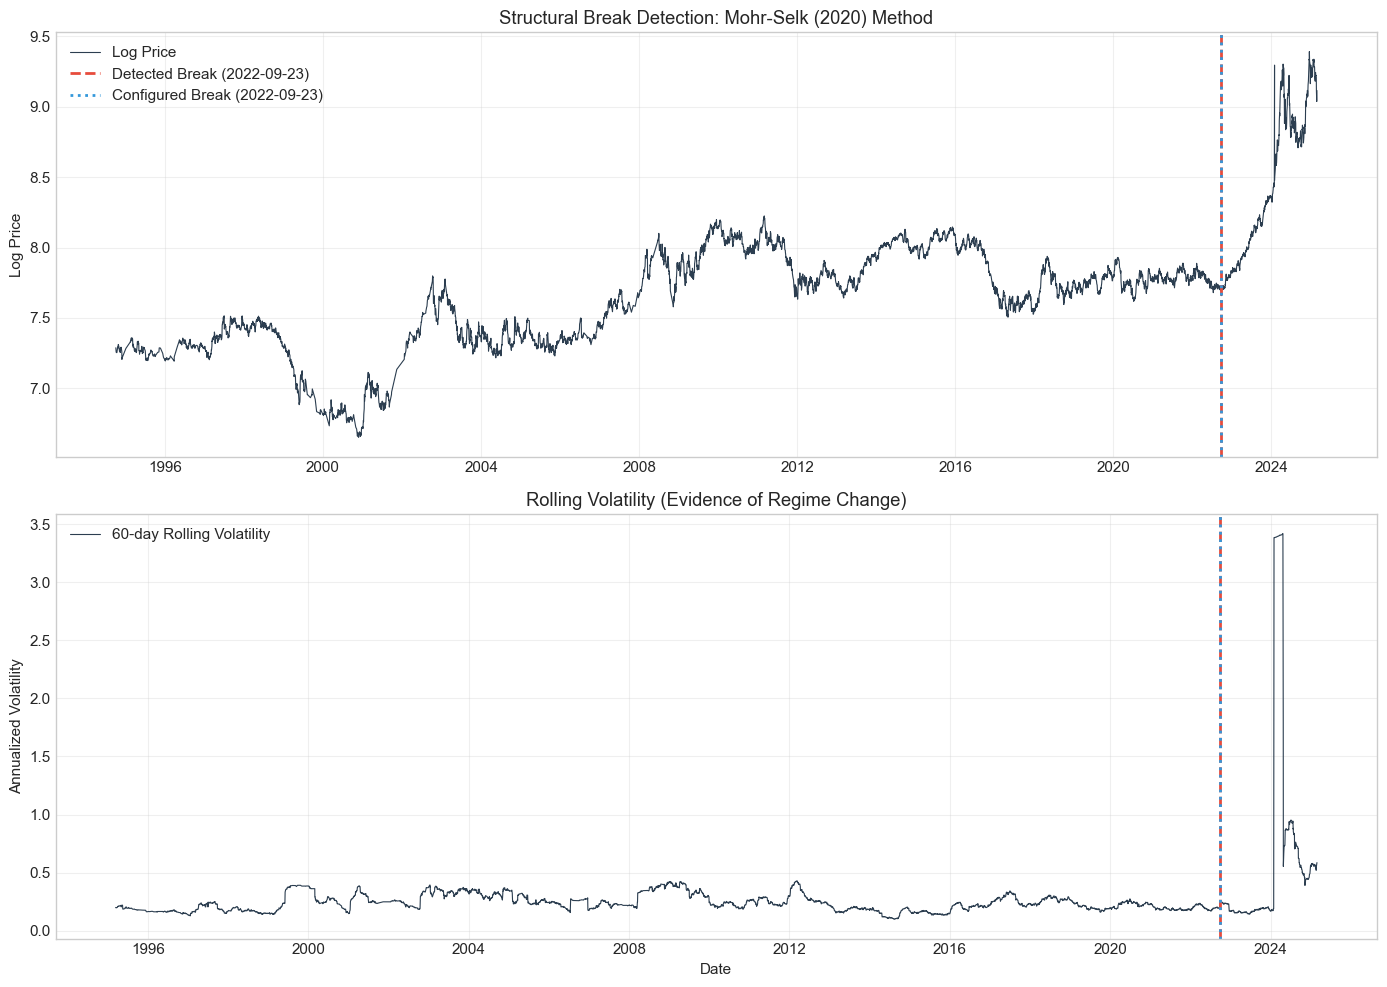


Break Detection Summary:
  The Mohr-Selk (2020) method detects a structural break at index 6117
  corresponding to date 2022-09-23.
  
  This aligns with the El Nino-driven supply disruption in the cocoa market,
  which induced significant changes in both the conditional mean and variance
  of log-returns in the post-break regime.


In [7]:
# Visualize the detected break point
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Log price with detected break
ax1 = axes[0]
ax1.plot(df['date'], df['log_price'], color='#2C3E50', linewidth=0.8, label='Log Price')
ax1.axvline(x=pd.Timestamp(detected_break_date), color='#E74C3C', linestyle='--', 
            linewidth=2, label=f'Detected Break ({detected_break_date_str})')
ax1.axvline(x=BREAK_DATE, color='#3498DB', linestyle=':', 
            linewidth=2, label=f'Configured Break ({BREAK_DATE.strftime("%Y-%m-%d")})')
ax1.set_ylabel('Log Price')
ax1.set_title('Structural Break Detection: Mohr-Selk (2020) Method')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling volatility to illustrate regime change
ax2 = axes[1]
rolling_vol = df['log_return'].rolling(window=60).std() * np.sqrt(252)  # Annualized
ax2.plot(df['date'], rolling_vol, color='#2C3E50', linewidth=0.8, label='60-day Rolling Volatility')
ax2.axvline(x=pd.Timestamp(detected_break_date), color='#E74C3C', linestyle='--', linewidth=2)
ax2.axvline(x=BREAK_DATE, color='#3498DB', linestyle=':', linewidth=2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Annualized Volatility')
ax2.set_title('Rolling Volatility (Evidence of Regime Change)')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print('\nBreak Detection Summary:')
print(f'  The Mohr-Selk (2020) method detects a structural break at index {T1_hat}')
print(f'  corresponding to date {detected_break_date_str}.')
print(f'  ')
print(f'  This aligns with the El Nino-driven supply disruption in the cocoa market,')
print(f'  which induced significant changes in both the conditional mean and variance')
print(f'  of log-returns in the post-break regime.')

## 4. Experiment Configuration

In [8]:
# Feature and target configuration
FEATURE_COLS = DEFAULT_FEATURE_COLS.copy()
TARGET_COL = DEFAULT_TARGET_COL
OOS_DATE = pd.to_datetime(OOS_START_DATE)

# Train/test split
train_mask = df['date'] < OOS_DATE
test_mask = df['date'] >= OOS_DATE

X_train_full = df.loc[train_mask, FEATURE_COLS].reset_index(drop=True)
y_train_full = df.loc[train_mask, TARGET_COL].reset_index(drop=True)
X_test = df.loc[test_mask, FEATURE_COLS].reset_index(drop=True)
y_test = df.loc[test_mask, TARGET_COL].reset_index(drop=True)
test_dates = df.loc[test_mask, 'date'].reset_index(drop=True)

# Break index relative to training data
TRAIN_BREAK_INDEX = min(BREAK_INDEX, len(X_train_full) - 1)

print('Experiment Configuration:')
print(f'  Features: {FEATURE_COLS}')
print(f'  Target: {TARGET_COL}')
print(f'  Training set: {len(X_train_full):,} observations')
print(f'  Test set (OOS): {len(X_test):,} observations')
print(f'  OOS Start: {OOS_DATE.strftime("%Y-%m-%d")}')
print(f'  Break index (training): {TRAIN_BREAK_INDEX}')
print(f'  MFV Folds (Q): {Q_VALUE}')

Experiment Configuration:
  Features: ['log_price_lagt']
  Target: log_return_forecast_target
  Training set: 6,694 observations
  Test set (OOS): 40 observations
  OOS Start: 2025-01-02
  Break index (training): 6116
  MFV Folds (Q): 4


## 5. Model Training

### 5.1 Non-Parametric Benchmarks

In [9]:
# Initialize NP components
kernel = EpanechnikovKernel()
local_engine = LocalPolynomialEngine(order=1, use_gpu=True)

# Bandwidth grid
T_train = len(X_train_full)
d = len(FEATURE_COLS)
bandwidth_grid = create_precentered_grid(T=T_train, d=d, C=1.0)

print(f'NP Configuration:')
print(f'  Kernel: Epanechnikov')
print(f'  Local Engine: Local Linear (order=1)')
print(f'  Dimension: {d}')
print(f'  Bandwidth grid: {len(bandwidth_grid)} candidates')
print(f'  Range: [{bandwidth_grid.min():.4f}, {bandwidth_grid.max():.4f}]')


def select_bandwidth_mfv(X_train, y_train, bandwidth_grid, kernel, local_engine, Q=4):
    """Select optimal bandwidth using Multi-Fold Forward Validation."""
    mfv = MFVValidator(Q=Q)
    param_grid = [
        {'kernel': kernel, 'local_engine': local_engine, 'bandwidth': h}
        for h in bandwidth_grid
    ]
    best_params, best_mse, _ = mfv.grid_search(
        model_class=NPRegimeModel,
        X_train=X_train, y_train=y_train,
        param_grid=param_grid, verbose=False
    )
    return best_params['bandwidth'], best_mse

LocalPolynomialEngine will use device: cuda
Creating bandwidth grid with T=6694, d=1
Generated bandwidth grid: [0.01717366 0.02864739 0.04778673 0.07971307 0.13296941 0.22180635
 0.36999529 0.61718934 1.02953386 1.71736599]
NP Configuration:
  Kernel: Epanechnikov
  Local Engine: Local Linear (order=1)
  Dimension: 1
  Bandwidth grid: 10 candidates
  Range: [0.0172, 1.7174]


In [10]:
# Pre-Break Local Linear Model
print('Training Pre-Break Local Linear Model...')

X_train_pre = X_train_full.iloc[:TRAIN_BREAK_INDEX]
y_train_pre = y_train_full.iloc[:TRAIN_BREAK_INDEX]

print(f'  Training size: {len(X_train_pre):,}')
print('  Selecting bandwidth via MFV...')

bw_pre, mse_pre_cv = select_bandwidth_mfv(
    X_train_pre, y_train_pre, bandwidth_grid, kernel, local_engine, Q=Q_VALUE
)

model_pre_ll = NPRegimeModel(kernel=kernel, local_engine=local_engine, bandwidth=bw_pre)
model_pre_ll.fit(X_train_pre, y_train_pre)

print(f'  Selected bandwidth: {bw_pre:.6f}')
print(f'  MFV MSE: {mse_pre_cv:.8f}')
print('  Model trained.')

Training Pre-Break Local Linear Model...
  Training size: 6,116
  Selecting bandwidth via MFV...
Set block size to 1223 for training length 6116 and Q=4.


  Selected bandwidth: 1.717366
  MFV MSE: 0.00025423
  Model trained.


In [11]:
# Post-Break Local Linear Model
print('Training Post-Break Local Linear Model...')

X_train_post = X_train_full.iloc[TRAIN_BREAK_INDEX:]
y_train_post = y_train_full.iloc[TRAIN_BREAK_INDEX:]

print(f'  Training size: {len(X_train_post):,}')
print('  Selecting bandwidth via MFV...')

bw_post, mse_post_cv = select_bandwidth_mfv(
    X_train_post, y_train_post, bandwidth_grid, kernel, local_engine, Q=Q_VALUE
)

model_post_ll = NPRegimeModel(kernel=kernel, local_engine=local_engine, bandwidth=bw_post)
model_post_ll.fit(X_train_post, y_train_post)

print(f'  Selected bandwidth: {bw_post:.6f}')
print(f'  MFV MSE: {mse_post_cv:.8f}')
print('  Model trained.')

Training Post-Break Local Linear Model...
  Training size: 578
  Selecting bandwidth via MFV...
Set block size to 115 for training length 578 and Q=4.
  Selected bandwidth: 1.717366
  MFV MSE: 0.00767773
  Model trained.


In [12]:
# Weighted Local Linear Model (CGS Method)
print('Training Weighted Local Linear (WLL) Model...')

mfv_combo = MFVConvexComboValidator(Q=Q_VALUE)
gamma_grid = np.linspace(0, 1, 21)

print(f'  Tuning gamma via MFV...')
print(f'  Gamma grid: {len(gamma_grid)} candidates')

params_pre_np = {'kernel': kernel, 'local_engine': local_engine, 'bandwidth': bw_pre}
params_post_np = {'kernel': kernel, 'local_engine': local_engine, 'bandwidth': bw_post}

best_gamma, best_gamma_mse = mfv_combo.tune_gamma(
    model_class_pre=NPRegimeModel, params_pre=params_pre_np,
    model_class_post=NPRegimeModel, params_post=params_post_np,
    X_train_full=X_train_full, y_train_full=y_train_full,
    break_index=TRAIN_BREAK_INDEX, gamma_grid=gamma_grid, verbose=False
)

model_wll = NPConvexCombinationModel(
    kernel=kernel, local_engine=local_engine,
    pre_bandwidth=bw_pre, post_bandwidth=bw_post,
    break_index=TRAIN_BREAK_INDEX, gamma=best_gamma
)
model_wll.fit(X_train_full, y_train_full)

print(f'  Optimal gamma: {best_gamma:.4f}')
print(f'  Interpretation: {best_gamma*100:.1f}% weight on pre-break model')
print(f'  MFV MSE: {best_gamma_mse:.8f}')
print('  Model trained.')

Training Weighted Local Linear (WLL) Model...
  Tuning gamma via MFV...
  Gamma grid: 21 candidates
Set block size to 115 for training length 578 and Q=4.
  Optimal gamma: 0.9500
  Interpretation: 95.0% weight on pre-break model
  MFV MSE: 0.00680709
  Model trained.


### 5.2 Machine Learning Competitors

In [13]:
# Random Forest
print('Training Random Forest...')

rf_param_combinations = [
    dict(zip(RF_PARAM_GRID.keys(), v))
    for v in product(*RF_PARAM_GRID.values())
]

print(f'  Grid size: {len(rf_param_combinations)} combinations')
print('  Running MFV hyperparameter tuning...')

mfv_rf = MFVValidator(Q=Q_VALUE)
best_rf_params, best_rf_mse, _ = mfv_rf.grid_search(
    model_class=RFModel,
    X_train=X_train_full, y_train=y_train_full,
    param_grid=rf_param_combinations, verbose=False
)

model_rf = RFModel(**best_rf_params)
model_rf.fit(X_train_full, y_train_full)

print(f'  Best params: {best_rf_params}')
print(f'  MFV MSE: {best_rf_mse:.8f}')
print('  Model trained.')

Training Random Forest...
  Grid size: 12 combinations
  Running MFV hyperparameter tuning...
Set block size to 1338 for training length 6694 and Q=4.


  Best params: {'n_estimators': 500, 'max_depth': 5, 'min_samples_leaf': 20, 'max_features': 'sqrt'}
  MFV MSE: 0.00082170
  Model trained.


In [14]:
# XGBoost
print('Training XGBoost...')

xgb_param_combinations = [
    dict(zip(XGB_PARAM_GRID.keys(), v))
    for v in product(*XGB_PARAM_GRID.values())
]

print(f'  Grid size: {len(xgb_param_combinations)} combinations')
print('  Running MFV hyperparameter tuning...')

mfv_xgb = MFVValidator(Q=Q_VALUE)
best_xgb_params, best_xgb_mse, _ = mfv_xgb.grid_search(
    model_class=XGBModel,
    X_train=X_train_full, y_train=y_train_full,
    param_grid=xgb_param_combinations, verbose=False
)

model_xgb = XGBModel(**best_xgb_params)
model_xgb.fit(X_train_full, y_train_full)

print(f'  Best params: {best_xgb_params}')
print(f'  MFV MSE: {best_xgb_mse:.8f}')
print('  Model trained.')

Training XGBoost...
  Grid size: 32 combinations
  Running MFV hyperparameter tuning...
Set block size to 1338 for training length 6694 and Q=4.


  Best params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.7}
  MFV MSE: 0.00082941
  Model trained.


### 5.3 ML Extension: Weighted ML Combinations

In [15]:
# Weighted RF Combo
print('Training Weighted RF Combo...')

mfv_rf_combo = MFVConvexComboValidator(Q=Q_VALUE)
best_gamma_rf, _ = mfv_rf_combo.tune_gamma(
    model_class_pre=RFModel, params_pre=best_rf_params,
    model_class_post=RFModel, params_post=best_rf_params,
    X_train_full=X_train_full, y_train_full=y_train_full,
    break_index=TRAIN_BREAK_INDEX, gamma_grid=gamma_grid, verbose=False
)

model_rf_combo = MLConvexCombinationModel(
    model_class=RFModel, params_pre=best_rf_params, params_post=best_rf_params,
    break_index=TRAIN_BREAK_INDEX, gamma=best_gamma_rf
)
model_rf_combo.fit(X_train_full, y_train_full)
print(f'  Optimal gamma: {best_gamma_rf:.4f}')

# Weighted XGB Combo
print('Training Weighted XGB Combo...')

mfv_xgb_combo = MFVConvexComboValidator(Q=Q_VALUE)
best_gamma_xgb, _ = mfv_xgb_combo.tune_gamma(
    model_class_pre=XGBModel, params_pre=best_xgb_params,
    model_class_post=XGBModel, params_post=best_xgb_params,
    X_train_full=X_train_full, y_train_full=y_train_full,
    break_index=TRAIN_BREAK_INDEX, gamma_grid=gamma_grid, verbose=False
)

model_xgb_combo = MLConvexCombinationModel(
    model_class=XGBModel, params_pre=best_xgb_params, params_post=best_xgb_params,
    break_index=TRAIN_BREAK_INDEX, gamma=best_gamma_xgb
)
model_xgb_combo.fit(X_train_full, y_train_full)
print(f'  Optimal gamma: {best_gamma_xgb:.4f}')

print('All models trained.')

Training Weighted RF Combo...
Set block size to 115 for training length 578 and Q=4.


  Optimal gamma: 0.7000
Training Weighted XGB Combo...
Set block size to 115 for training length 578 and Q=4.


  Optimal gamma: 1.0000
All models trained.


## 6. Out-of-Sample Evaluation

In [16]:
# Generate predictions
print('Generating out-of-sample predictions...')

predictions = {
    'Pre-Break LL': model_pre_ll.predict(X_test),
    'Post-Break LL': model_post_ll.predict(X_test),
    'WLL': model_wll.predict(X_test),
    'Random Forest': model_rf.predict(X_test),
    'XGBoost': model_xgb.predict(X_test),
    'RF Combo': model_rf_combo.predict(X_test),
    'XGB Combo': model_xgb_combo.predict(X_test),
}

# Compute MSFE
results = {name: mean_squared_error(y_test, pd.Series(preds))
           for name, preds in predictions.items()}

# Results table
results_df = pd.DataFrame([
    {'Model': name, 'MSFE': mse, 'RMSFE': np.sqrt(mse)}
    for name, mse in results.items()
]).sort_values('MSFE')

results_df['Rank'] = range(1, len(results_df) + 1)
best_msfe = results_df['MSFE'].min()
results_df['Relative (%)'] = (results_df['MSFE'] / best_msfe - 1) * 100

print('\n' + '='*70)
print('MEAN SQUARED FORECAST ERROR (MSFE) RESULTS')
print('='*70)
print(results_df[['Rank', 'Model', 'MSFE', 'RMSFE', 'Relative (%)']].to_string(index=False))
print('='*70)
print(f'\nBest Model: {results_df.iloc[0]["Model"]} (MSFE = {best_msfe:.8f})')

Generating out-of-sample predictions...

MEAN SQUARED FORECAST ERROR (MSFE) RESULTS
 Rank         Model     MSFE    RMSFE  Relative (%)
    1           WLL 0.000942 0.030700      0.000000
    2  Pre-Break LL 0.000943 0.030706      0.042678
    3     XGB Combo 0.000950 0.030824      0.808613
    4      RF Combo 0.001003 0.031663      6.371883
    5 Post-Break LL 0.001101 0.033176     16.778409
    6 Random Forest 0.001239 0.035196     31.433508
    7       XGBoost 0.001304 0.036115     38.387813

Best Model: WLL (MSFE = 0.00094248)


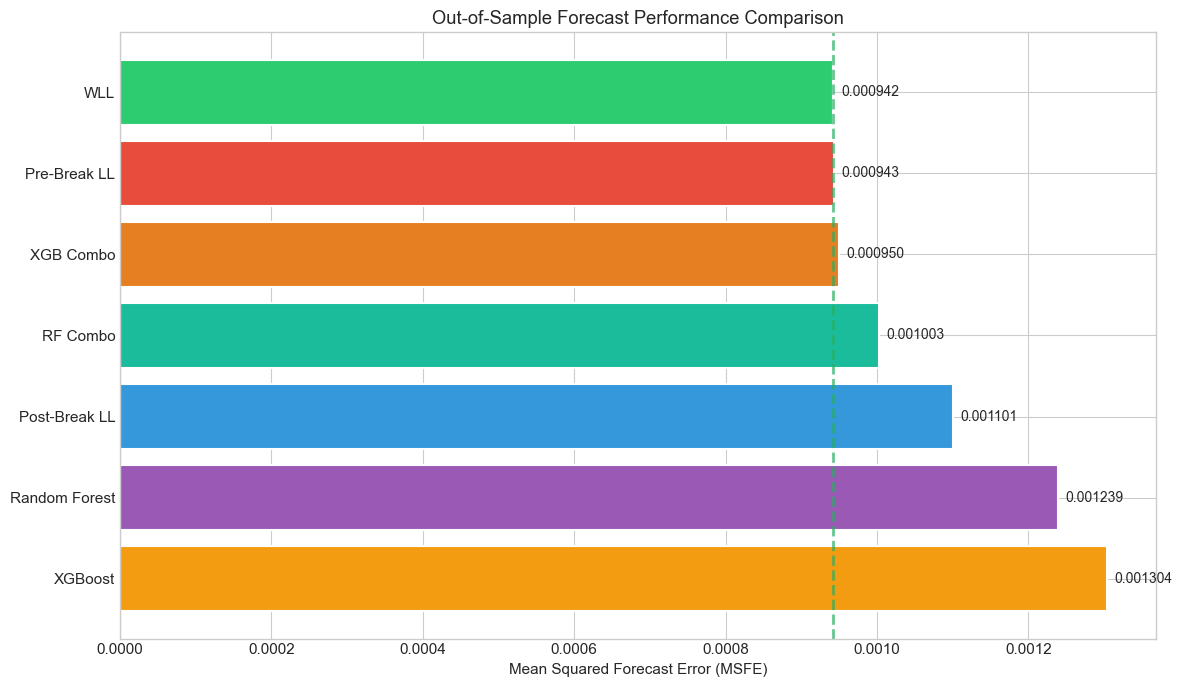

In [17]:
# MSFE comparison chart
model_colors = {
    'Pre-Break LL': COLORS['pre_break'],
    'Post-Break LL': COLORS['post_break'],
    'WLL': COLORS['wll'],
    'Random Forest': COLORS['rf'],
    'XGBoost': COLORS['xgb'],
    'RF Combo': COLORS['rf_combo'],
    'XGB Combo': COLORS['xgb_combo'],
}

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(
    results_df['Model'], results_df['MSFE'],
    color=[model_colors.get(m, '#95A5A6') for m in results_df['Model']],
    edgecolor='white', linewidth=1.5
)

for bar, msfe in zip(bars, results_df['MSFE']):
    ax.text(bar.get_width() + 0.00001, bar.get_y() + bar.get_height()/2,
            f'{msfe:.6f}', va='center', fontsize=10)

ax.set_xlabel('Mean Squared Forecast Error (MSFE)')
ax.set_title('Out-of-Sample Forecast Performance Comparison')
ax.invert_yaxis()
ax.axvline(x=best_msfe, color='#27AE60', linestyle='--', linewidth=2, alpha=0.7)
plt.tight_layout()
plt.show()

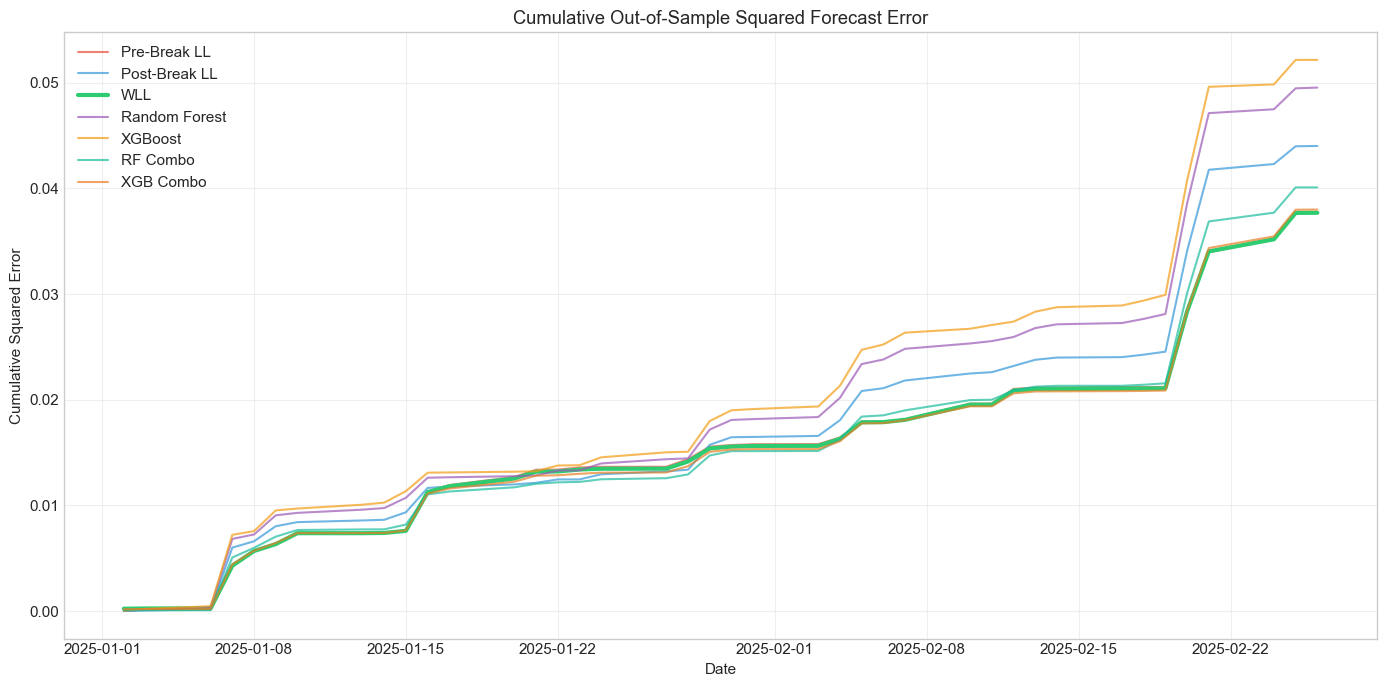

In [18]:
# Cumulative squared error over time
fig, ax = plt.subplots(figsize=(14, 7))

for name, preds in predictions.items():
    sq_err = (y_test.values - preds) ** 2
    cum_se = np.cumsum(sq_err)
    color = model_colors.get(name, '#95A5A6')
    lw = 3 if name == 'WLL' else 1.5
    alpha = 1.0 if name == 'WLL' else 0.7
    ax.plot(test_dates, cum_se, label=name, color=color, linewidth=lw, alpha=alpha)

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Squared Error')
ax.set_title('Cumulative Out-of-Sample Squared Forecast Error')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Modified Diebold-Mariano Test

In [19]:
def modified_dm_test(y_true, pred1, pred2, h=1, power=2):
    """Modified Diebold-Mariano test for forecast comparison."""
    e1, e2 = y_true - pred1, y_true - pred2
    d = np.abs(e1)**power - np.abs(e2)**power
    n = len(d)
    d_bar = np.mean(d)
    gamma_0 = np.var(d, ddof=1)
    
    gamma_sum = sum(2 * (1 - k/h) * np.mean((d[k:] - d_bar) * (d[:-k] - d_bar))
                    for k in range(1, h))
    var_d = (gamma_0 + gamma_sum) / n
    
    if var_d <= 0:
        return np.nan, np.nan
    
    dm_stat = d_bar / np.sqrt(var_d)
    correction = np.sqrt((n + 1 - 2*h + h*(h-1)/n) / n)
    mdm_stat = dm_stat * correction
    p_value = 2 * stats.t.sf(np.abs(mdm_stat), df=n-1)
    return mdm_stat, p_value

# Pairwise MDM tests
y_true_arr = y_test.values
model_names = list(predictions.keys())

mdm_matrix = pd.DataFrame(index=model_names, columns=model_names, dtype=float)
pval_matrix = pd.DataFrame(index=model_names, columns=model_names, dtype=float)

for m1 in model_names:
    for m2 in model_names:
        if m1 == m2:
            mdm_matrix.loc[m1, m2] = 0.0
            pval_matrix.loc[m1, m2] = 1.0
        else:
            stat, pval = modified_dm_test(y_true_arr, predictions[m1], predictions[m2])
            mdm_matrix.loc[m1, m2] = stat
            pval_matrix.loc[m1, m2] = pval

print('MDM Test Statistics (positive = row model worse than column):')
print(mdm_matrix.round(3).to_string())
print('\nP-Values:')
print(pval_matrix.round(3).to_string())

MDM Test Statistics (positive = row model worse than column):
               Pre-Break LL  Post-Break LL    WLL  Random Forest  XGBoost  RF Combo  XGB Combo
Pre-Break LL          0.000         -1.218  0.062         -1.733   -1.930    -0.807     -0.336
Post-Break LL         1.218          0.000  1.285         -3.218   -3.324     1.715      1.387
WLL                  -0.062         -1.285  0.000         -1.804   -2.000    -0.889     -0.503
Random Forest         1.733          3.218  1.804          0.000   -3.396     2.435      1.932
XGBoost               1.930          3.324  2.000          3.396    0.000     2.659      2.134
RF Combo              0.807         -1.715  0.889         -2.435   -2.659     0.000      0.998
XGB Combo             0.336         -1.387  0.503         -1.932   -2.134    -0.998      0.000

P-Values:
               Pre-Break LL  Post-Break LL    WLL  Random Forest  XGBoost  RF Combo  XGB Combo
Pre-Break LL          1.000          0.231  0.951          0.091    0.06

## 8. Summary

In [20]:
print('='*70)
print('EXPERIMENT SUMMARY')
print('='*70)

print(f'\nData:')
print(f'  Training: {df["date"].min().strftime("%Y-%m-%d")} to {OOS_DATE.strftime("%Y-%m-%d")}')
print(f'  Test: {OOS_DATE.strftime("%Y-%m-%d")} to {df["date"].max().strftime("%Y-%m-%d")}')
print(f'  Structural break: {BREAK_DATE.strftime("%Y-%m-%d")}')

print(f'\nHyperparameters:')
print(f'  Pre-break bandwidth: {bw_pre:.6f}')
print(f'  Post-break bandwidth: {bw_post:.6f}')
print(f'  WLL gamma: {best_gamma:.4f}')
print(f'  RF Combo gamma: {best_gamma_rf:.4f}')
print(f'  XGB Combo gamma: {best_gamma_xgb:.4f}')

print(f'\nResults (MSFE):')
for _, row in results_df.iterrows():
    print(f'  {row["Rank"]}. {row["Model"]}: {row["MSFE"]:.8f} ({row["Relative (%)"]:.2f}%)')

wll_msfe = results['WLL']
post_msfe = results['Post-Break LL']
best_ml = min(['Random Forest', 'XGBoost'], key=lambda x: results[x])
best_ml_msfe = results[best_ml]

print(f'\nKey Comparisons:')
print(f'  WLL vs Post-Break LL: {(wll_msfe/post_msfe - 1)*100:+.2f}%')
print(f'  WLL vs {best_ml}: {(wll_msfe/best_ml_msfe - 1)*100:+.2f}%')

print('\n' + '='*70)

EXPERIMENT SUMMARY

Data:
  Training: 1994-10-04 to 2025-01-02
  Test: 2025-01-02 to 2025-02-26
  Structural break: 2022-09-23

Hyperparameters:
  Pre-break bandwidth: 1.717366
  Post-break bandwidth: 1.717366
  WLL gamma: 0.9500
  RF Combo gamma: 0.7000
  XGB Combo gamma: 1.0000

Results (MSFE):
  1. WLL: 0.00094248 (0.00%)
  2. Pre-Break LL: 0.00094288 (0.04%)
  3. XGB Combo: 0.00095010 (0.81%)
  4. RF Combo: 0.00100254 (6.37%)
  5. Post-Break LL: 0.00110062 (16.78%)
  6. Random Forest: 0.00123874 (31.43%)
  7. XGBoost: 0.00130428 (38.39%)

Key Comparisons:
  WLL vs Post-Break LL: -14.37%
  WLL vs Random Forest: -23.92%



In [21]:
# Save results
output_dir = Path.cwd().parent / 'output' / 'experiment_results'
output_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

results_df.to_csv(output_dir / f'msfe_results_{timestamp}.csv', index=False)
mdm_matrix.to_csv(output_dir / f'mdm_statistics_{timestamp}.csv')
pval_matrix.to_csv(output_dir / f'mdm_pvalues_{timestamp}.csv')

pred_df = pd.DataFrame(predictions)
pred_df['date'] = test_dates.values
pred_df['y_true'] = y_test.values
pred_df.to_csv(output_dir / f'predictions_{timestamp}.csv', index=False)

print(f'Results saved to: {output_dir}')

Results saved to: W:\Research\NP\Cocoa\output\experiment_results
